# Grover-Rudolph algorithm

At this point, we have become very familiar with operating in the computational basis of quantum states, and now know how to perform quantum arithmetic to prepare a derised state in this basis. 

Now let's look at how we can prepare states of a desired amplitude using our tools we have developed while working in the computational basis. If we have a quantum register $|0\rangle^{\otimes n_x}$ of $n_x$ qubits, and a set of known probabilities $\{p(x_i)\}^{2^{n_x}-1}_{i=0}$, can we preform the operation:

\begin{align}
|0\rangle^{\otimes n_x} \rightarrow \sum^{2^{n_x}-1}_{i=0}\sqrt{p(x_i)}|i\rangle,
\end{align}


and can it be done efficiently? We can use the *Grover-Rudolph algorithm* to prepare such a state, and combine this with our linear piecewise function approximation from before to make it efficient.

The Grover-Rudolph algorithm is an iterative process applied to each ${m=0,\dots,n_x-1}$ qubits, where each step involves dividing the target distribution into ${j=0,\dots,2^{m}-1}$ bins. For a given $m$ and $j$, we can define the angle:

\begin{align}\label{equ:zeta}
\zeta_{m,j} = \arccos\left(\sqrt{\frac{\sum_{i=j2^{n_x-m}}^{(j+1/2)2^{n_x-m}}p(x_i)}{\sum_{l=j2^{n_x-m}}^{(j+1)2^{n_x-m}}p(x_l)}}\right)
\end{align}

The value $\cos^{2}\zeta_{m,j}$ is the ratio of $p(x)$ in the left-most half of bin $j$ compared to the whole domain of $j$. This is illustrated in the figure below. Initially, $m=0$ and therefore $j=0$ meaning that domain $j$ spans the whole region of interest. This domain is then split in half, and $\cos^{2}\zeta_{0,0}$ is the fraction of the probability in the left-most half compared to the whole interval.

<img src="GR_algorithm.png" width="400">

For $m=1$, we have two domains of $j=0$ and $j=1$. Then both of these domains are split in half and the fraction of probability that lies in the left-most half of each domain is equal to $\cos^{2}\zeta_{1,0}$ and $\cos^{2}\zeta_{1,1}$.

With this in mind, the Grover-Rudolph algorithm is performed by repeating the following two steps sequentially for qubit $m$ in $0,2^{n_x} - 1$ and given state $\sum^{2^m - 1}_{j=0}\sqrt{p_j^{(m)}}|i\rangle$, where $p_{j}^{(m)}$ denotes the $j$th probability bin of the $2^{m}$ bins over domain of interest:
      
   1. Initialize the angle state $\sum^{2^m - 1}_{j=0}\sqrt{p_j^{(m)}}|j\rangle|0\rangle\rightarrow \sum^{2^m - 1}_{j=0}\sqrt{p_j^{(m)}}|j\rangle|\zeta_{m,j}\rangle$.
   2. Introduce qubit $m+1$ and perform the controlled rotation $\sum^{2^m - 1}_{j=0}\sqrt{p_j^{(m)}}|j\rangle|\zeta_{m,j}\rangle|0\rangle_{m+1}\rightarrow \sum^{2^m - 1}_{j=0}\sqrt{p_j^{(m)}}|j\rangle|\zeta_{m,j}\rangle(\cos\zeta_{m,j}|0\rangle_{m+1} + \sin\zeta_{m,j}|1\rangle_{m+1}) $.
   
You may ask, why do we bother writing $\zeta_{m,j}$ into the computational basis of an ancillary register at all? Why do we not just directly apply the rotations directly onto qubit $m+1$? Let us first explore this case in the first example.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qiskit.circuit.library.standard_gates import RYGate

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

Let us first define a probability distribution $p(x)$ we wish to encode:

In [3]:
def targ_dist(x, bias=0):
    y = (x+bias)**(-7./6)
    return y/np.sqrt(np.sum(np.abs(y)**2))    

Now we define an $x$ range for which we wish to evaluate $p(x)$:

In [4]:
nx = 6
nintx = 4

xmin = -2.**(nintx)
xmax = 2.**(nintx) - 2.**(-nx+nintx+1)
xs = np.linspace(xmin, xmax, 2**nx)

Now we define our target amplitudes and probabilities that we wish to encode onto our $x$ register:

In [5]:
amps = targ_dist(xs, bias=2.**(nintx+1))
probs = np.abs(amps)**2

Let us have a look at the target amplitudes:

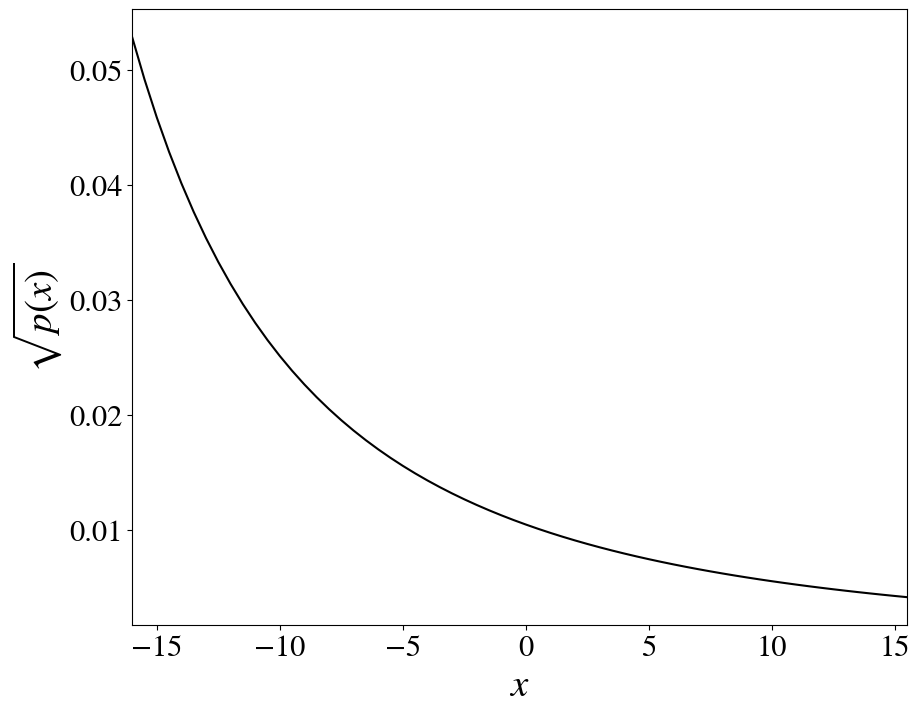

In [6]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.plot(xs, probs, color='black')
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$\sqrt{p(x)}$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);

Now let us encode Equ. [1](#mjx-eqn-equ:zeta) into a function:

In [7]:
def GR_func(j, probs, m, n):
    j = np.array(j).astype(int)
    As = []
    for i in np.arange(2**m):
        As.append(np.sum(probs[i*2**(n-m):(i+1)*2**(n-m)]))
    As1 = []
    for i in np.arange(2**(m+1)):
        As1.append(np.sum(probs[i*2**(n-(m+1)):(i+1)*2**(n-(m+1))]))
    return np.arccos(np.sqrt(np.array(As1)[::2][j]/np.array(As)[j]))

Let us begin with a single $x$ register:

In [8]:
qx = QuantumRegister(nx, 'x')
circ = QuantumCircuit(qx)

The case for $m=0$ requires a single gate rotation of $\zeta_{0,0}$ and so is just simply:

In [9]:
coeffs = np.arccos(np.sqrt(np.sum(probs[:2**(nx-1)])))
circ.ry(2*coeffs, qx[nx-1]);

For $m>0$, it is not so simple, and we require a controlled operation conditioned on every configuration of the $m$ qubits:

In [10]:
for m in np.arange(1,nx):
    js = np.arange(2**m)
    coeffs = GR_func(js, probs, m, nx)
    
    for j in np.arange(2**m):
        control_bits = qt.my_binary_repr(j, m, nint=None, phase=False)
        if j>0:
            control_bits_ = qt.my_binary_repr(j-1, m, nint=None, phase=False)[::-1]
        else:
            control_bits_ = np.ones(m).astype(int).astype(str)
        
        for i,control_bit in enumerate(control_bits[::-1]):
            if control_bit=='0' and control_bits_[i]=='1':
                circ.x(qx[nx-i-1]);

        R_gate = RYGate(2*coeffs[j]).control(int(m))
        circ.append(R_gate, [*qx[nx-m-1:][::-1]]);

        if j<2**m-1:
            control_bits_ = qt.my_binary_repr(j+1, m, nint=None, phase=False)[::-1]
        else:
            control_bits_ = np.ones(m).astype(int).astype(str)

        for i,control_bit in enumerate(control_bits[::-1]):
            if control_bit=='0' and control_bits_[i]=='1':
                circ.x(qx[nx-i-1]);

Let us see what this state vector looks like with the simulator:

In [11]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

Let us just trim away the imaginary part of the state vector if it does not exist...

In [12]:
if np.any(state_vector.imag>0.):
    state_v = np.copy(state_vector)
else:
    state_v = state_vector.real

and plot the state vector over the domain compared to our target amplitudes:

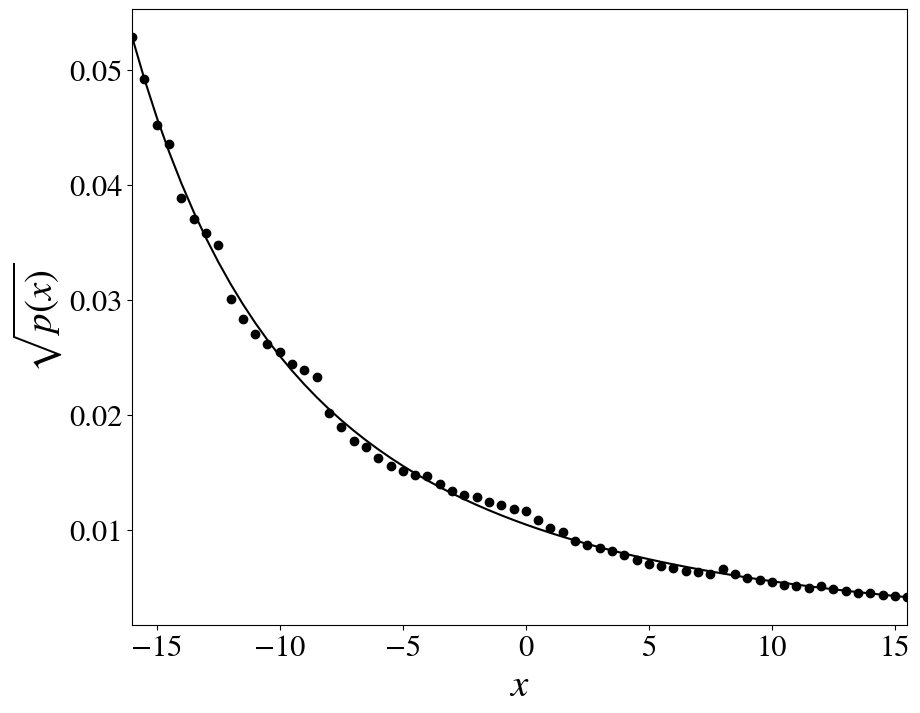

In [13]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.scatter(xs, np.abs(state_v)**2, color='black')
ax.plot(xs, probs, color='black')
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$\sqrt{p(x)}$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);

Looks great!

However, let us take a look at this circuit:

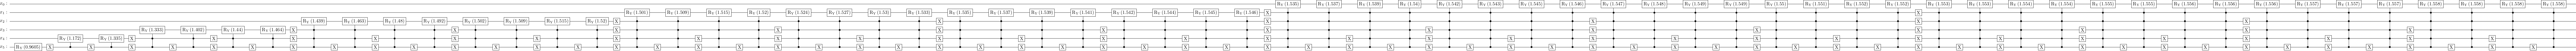

In [14]:
circ.draw('latex')

Ah, it blows up exponetially in size with larger $n_x$ - this is not efficient computing. However if we can efficiently perform the first step of initializing the angle states $|\zeta_{m,j}\rangle$, then we avoid this exponentially large expense of performing each individual rotation. Luckily, we just mastered performing linear piecewise function approximation in the computational basis in the previous notebooks, so we can use this to help us out here!

Let us introduce ancillary registers of length:

In [15]:
# Register size for storing the zeta angles
nanc = 8
# Register size for storing the linear coefficients for the piecewise function 
ncoff = 8
# Register size for the label register
nlab = 4

This requires qubits:

In [16]:
print('Qubits:', nx, nanc, ncoff, nlab,'total:',nanc+ncoff+nx+nlab)
print('Memory:', 16*(2**(nanc+ncoff+nx+nlab))/2**20)

Qubits: 6 8 8 4 total: 26
Memory: 1024.0


Let us initialize our registers as usual:

In [17]:
qx = QuantumRegister(nx, 'x')
qanc = QuantumRegister(nanc, 'anc')
qlab = QuantumRegister(nlab, 'l')
qcoff = QuantumRegister(ncoff, 'c')
circ = QuantumCircuit(qx, qanc, qlab, qcoff)

It is worth noting, that while the previous example becomes computationally costly for high $m$, it is convenient to use it for low values of $m$. For example, when $m=0$, only a single qubit rotation gate is required, which is the minimal computational cost for an operation. We therefore define a threshold value $m_{low}$ where we apply the above strategy for $m\le m_{low}$:

In [18]:
mlow = 4

We can then apply the previous strategy for $m\le m_{low}$ through the function `Grover_Rudolph_load`. We must first appropriately divide the probabilities in the domain into the $2^{m_{low}}$ bins to pass to the function as an arguement:

In [19]:
probs_ = []
for i in np.arange(2**mlow):
    probs_.append(np.sum(probs[i*2**(nx-mlow):(i+1)*2**(nx-mlow)]))
probs_ = np.array(probs_)

GRl_gate = qt.Grover_Rudolph_load(circ, qx[nx-mlow:], probs_, wrap=True)
circ.append(GRl_gate, qx[nx-mlow:]);

We can then use the linear piecewise function approximation to approximate $|\zeta_{m,j}\rangle$ efficiently for $m>m_{low}$:

In [20]:
for m in np.arange(mlow,nx):
    
    js = np.arange(2**m)
    coeffs = GR_func(js, probs, m, nx)

    f_x = lambda x: GR_func(x, probs, m, nx)
    
    bounds_ = np.linspace(0,2**m,(2**nlab)+1).astype(int)
    coeffs = qt.get_bound_coeffs(f_x, bounds_, 1, reterr=False).T#[::-1]
    bounds = bounds_[1:]

    max_list0 = np.array([coeffs[0], coeffs[1], coeffs[0]*2**nx, (coeffs[0]*2**nx)+coeffs[-1]])
    max_list1 = max_list0
    nintcs = []
    nintcs.append(int(np.ceil(np.log2(np.max(np.abs(max_list0))))))
    nintcs.append(int(np.ceil(np.log2(np.max(np.abs(max_list1))))))
    nint = nintcs[-1]
    nintcs = np.array([nintcs])

    func_gate = qt.linear_piecewise_approx(circ, qx[nx-m:], qanc, qlab, qcoff, coeffs, bounds, nint=nint, nintx=nx, nintcs=nintcs, phase=False, wrap=True)
    circ.append(func_gate, [*qx[nx-m:], *qanc, *qlab, *qcoff]);

    rot_gate = qt.CRotation(circ, qanc, qx[nx-m-1], nint=nint, wrap=True)
    circ.append(rot_gate, [*qanc, qx[nx-m-1]])

    func_gate_inv = qt.linear_piecewise_approx(circ, qx[nx-m:], qanc, qlab, qcoff, coeffs, bounds, nint=nint, nintx=nx, nintcs=nintcs, phase=False, wrap=True, inverse=True)
    circ.append(func_gate_inv, [*qx[nx-m:], *qanc, *qlab, *qcoff]);

Let us see what this looks like:

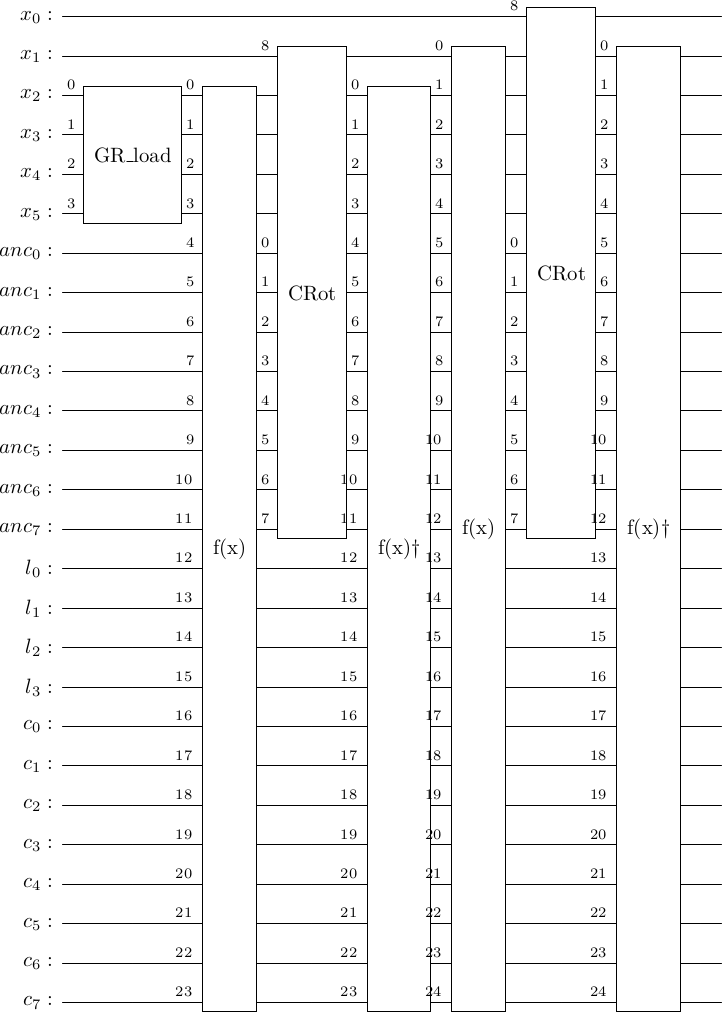

In [21]:
circ.draw('latex')

We can see that the linear piecewise function approximation is applied to $m$ qubits from register $x$ for a given $m$. The computational cost of this operation scales polynomially with the number of $x$ qubits, and not exponentially. Therefore we can deem this operation efficient!

Let us take a look at the state vector to see if the result is satisfactory:

In [22]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [23]:
if np.any(state_vector.imag>0.):
    state_v = np.copy(state_vector)
else:
    state_v = state_vector.real

In [24]:
state_v = np.asarray(state_vector).reshape((2**ncoff,2**nlab,2**nanc,2**nx)).T
state_v = np.sum(state_v, axis=(1,2,3))

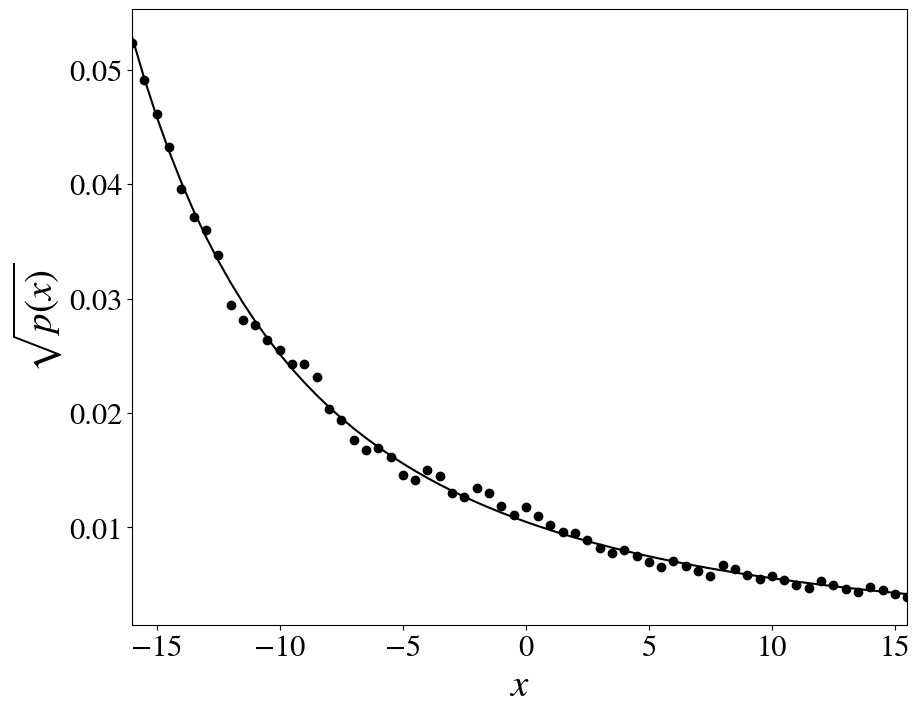

In [25]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.scatter(xs, np.abs(state_v)**2, color='black')
ax.plot(xs, probs, color='black')
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$\sqrt{p(x)}$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);

This looks good! You may notice that this is less accurate than the direct rotation method. This is due to the limitated number of qubits used to store the value of $\zeta_{m,j}$ on, limiting the precision. It is also due to the limitations of the piecewise polynomial approximation, and the error caused by disregarding higher order polynomial terms.